# Purpose
1. 請為客戶進行貼標，並依其特性進行命名，以幫助行銷部門推出新產品和制定行銷方式。
2. 請先進行降維後再分群(依你的判斷選擇降維和分群的方法)

In [84]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as hcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# 1. import data

In [85]:
df = pd.read_csv('segmentation_data.csv')
df.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


#### ID：顯示客戶的唯一標識。

#### Sex：
0：男性        
1：女性        

#### Marital status：客戶的婚姻狀況。
0：單人        
1：非單身（離婚/分居/已婚/喪偶）        

#### Age：客戶的年齡（以年為單位），計算方法為當年減去創建數據集時客戶的出生年份
18 最小值（數據集中觀察到的最低年齡）        
76 最大值（數據集中觀察到的最高年齡）        

#### Education：客戶的教育水準。
0：其他/未知        
1：高中        
2：大學        
3：研究生院        

#### Income：客戶以美元自我報告的年收入。
35832 最小值（數據集中觀察到的最低收入）        
309364 最大值（數據集中觀察到的最高收入）        

#### Occupation ：客戶的職業類別。
0：失業 / unskilled        
1：skilled employee / official        
2：management / self-employed / highly qualified employee / officer        

#### Settlement size：客戶居住城市的規模。
0：小城市        
1：中等城市        
2：大城市        

In [87]:
# drop ID 欄位
df=df.drop(columns=['ID'])
df_origin = df.copy()

In [88]:
# 基礎統計分析
print(df.isnull().sum())

df.describe()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


In [89]:
# 資料標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Age', 'Income']] = scaler.fit_transform(df[['Age', 'Income']])
df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,0,0,2.653614,2,0.097524,1,2
1,1,1,-1.187132,1,0.782654,1,2
2,0,0,1.117316,1,-0.833202,0,0
3,0,0,0.775916,1,1.328386,1,1
4,0,0,1.458716,1,0.736932,1,1


## PCA

In [90]:
# 每個因子各自解釋多少變異
pca_7d = PCA(7, random_state=123)
pca_7d.fit(df)
np.round(pca_7d.explained_variance_ratio_, 2)

array([0.45, 0.25, 0.12, 0.09, 0.04, 0.03, 0.01])

In [91]:
# 前3大主成分就已解釋了數值中8成的差異
sum(pca_7d.explained_variance_ratio_.tolist()[:3])

0.826892743423862

Text(0, 0.5, 'cumulative explained variance')

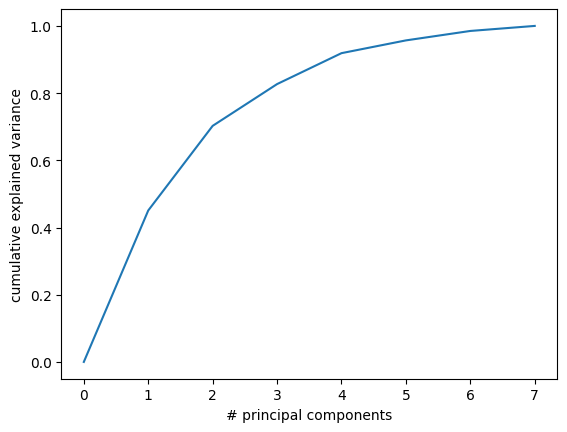

In [92]:
# 第一個位置為第一主成份的變異，所以要加0在第一個位置
var_plot = [0] + pca_7d.explained_variance_ratio_.tolist()

cum_explained_var_ratio = np.cumsum(var_plot)
plt.plot(cum_explained_var_ratio)
plt.xlabel('# principal components')
plt.ylabel('cumulative explained variance')

In [93]:
# 選擇三個主成分
pca = PCA(n_components=3, random_state=123)

# 對標準化後的特徵做PCA
pca_trans = pca.fit_transform(df)

In [94]:
# 三個主成分的內容
pcs = np.array(pca.components_)

df_pc = pd.DataFrame(pcs, columns=df.columns)
df_pc.index = [f"No.{c} factor" for c in range(1,4)]
df_pc.style\
    .background_gradient(cmap='PuBu', axis=None)\
    .format("{:.2}")

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
No.1 factor,-0.11,-0.058,0.5,0.2,0.66,0.33,0.39
No.2 factor,0.076,0.0057,0.73,0.38,-0.27,-0.31,-0.39
No.3 factor,0.54,0.6,-0.24,0.39,0.28,0.11,-0.23


## K-Means

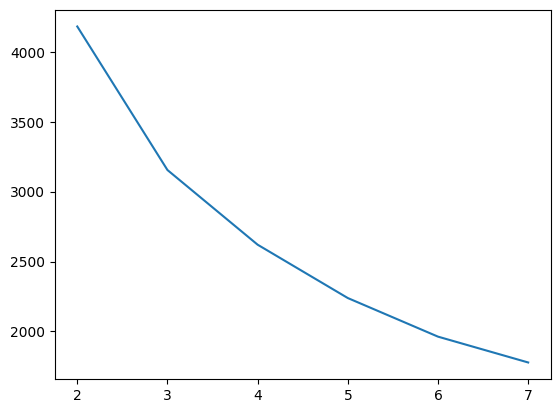

In [95]:
# 判斷群數 手肘法則
clusters=list(range(2,8))
ssd = []
for num_clusters in clusters:
    model_clus = KMeans(n_clusters = num_clusters, max_iter=150,random_state= 50)
    model_clus.fit(pca_trans)
    ssd.append(model_clus.inertia_)

plt.plot(clusters, ssd)

In [96]:
# 按照手肘法則考慮分3或4群 再對照輪廓係數法
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50,random_state= 100)
    kmeans.fit(pca_trans)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(pca_trans, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.3479646913296225
For n_clusters=3, the silhouette score is 0.3148195172611472
For n_clusters=4, the silhouette score is 0.26831670432694
For n_clusters=5, the silhouette score is 0.29269602744364126
For n_clusters=6, the silhouette score is 0.29771259805553346
For n_clusters=7, the silhouette score is 0.2958817933965799
For n_clusters=8, the silhouette score is 0.2930182164397746


In [139]:
# 綜合上述結果 分3群
cluster = KMeans(n_clusters = 3, random_state = 111)
cluster.fit(pca_trans)
# 看一下各群數量
pd.Series(cluster.labels_).value_counts()

1    966
0    678
2    356
Name: count, dtype: int64

## K-Means 結果分析

In [140]:
# 將分群結果併回原始資料 並做分群基礎數值分析
pred = pd.DataFrame(cluster.labels_, columns=['k_cluster'])
kmeans_result_origin = pd.concat([df_origin.reset_index(drop=True), pred], axis=1)
kmeans_result_origin.groupby(['k_cluster'], as_index=True).mean()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
k_cluster,,,,,,,
0,0.230088,0.380531,32.168142,0.790560,138241.660767,1.212389,1.455752
1,0.650104,0.583851,31.407867,0.924431,96600.371636,0.430642,0.119048
2,0.365169,0.480337,55.247191,1.817416,154115.261236,1.075843,1.056180


In [103]:
df_origin.describe()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000
mean,0.457000,0.496500,35.909000,1.03800,120954.419000,0.810500,0.739000
std,0.498272,0.500113,11.719402,0.59978,38108.824679,0.638587,0.812533
min,0.000000,0.000000,18.000000,0.00000,35832.000000,0.000000,0.000000
25%,0.000000,0.000000,27.000000,1.00000,97663.250000,0.000000,0.000000
50%,0.000000,0.000000,33.000000,1.00000,115548.500000,1.000000,1.000000
75%,1.000000,1.000000,42.000000,1.00000,138072.250000,1.000000,1.000000
max,1.000000,1.000000,76.000000,3.00000,309364.000000,2.000000,2.000000


## 結論

- 第0群 白手起家的年輕單身都會男子 通常鼓吹學歷無用論 喜歡高端奢侈品 追求外在形象
- 第1群 鄉下的年輕少婦 通常以家庭為重心 講求cp值 實用性 與家庭相關的用品
- 第2群 中年已婚高學歷高收入族群 重視服務 品質 品牌忠誠度高 且可能有健康方面的需求